In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-classification-mri


In [20]:
#Define Directories
train_dir = '/kaggle/input/brain-tumor-classification-mri/Training'
test_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'


In [60]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

# === 1. Setup Paths and Parameters ===
train_dir = '/kaggle/input/brain-tumor-classification-mri/Training'
test_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'
img_size = 224
batch_size = 32
fine_tune_at = 60
num_classes = 4

# === 2. Custom Callback for Tracking ===
class EpochTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.lrs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
        self.lrs.append(float(tf.keras.backend.get_value(self.model.optimizer.learning_rate)))


    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.start_time)

# === 3. Data Generators with Strong Augmentation ===
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1./255)

train_flow = train_gen.flow_from_directory(train_dir, target_size=(img_size, img_size),
                                           batch_size=batch_size, class_mode='categorical',
                                           subset='training', shuffle=True)
val_flow = train_gen.flow_from_directory(train_dir, target_size=(img_size, img_size),
                                         batch_size=batch_size, class_mode='categorical',
                                         subset='validation', shuffle=True)
test_flow = test_gen.flow_from_directory(test_dir, target_size=(img_size, img_size),
                                         batch_size=batch_size, class_mode='categorical',
                                         shuffle=False)

# === 4. Compute Class Weights ===
class_weights = compute_class_weight('balanced',
                                     classes=np.unique(train_flow.classes),
                                     y=train_flow.classes)
class_weights = dict(enumerate(class_weights))

# === 5. Build Model ===
base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])



Found 2441 images belonging to 4 classes.
Found 429 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [34]:
# === 6. Initial Training ===
tracker1 = EpochTracker()
print("Initial Training")
history1 = model.fit(train_flow, validation_data=val_flow, epochs=10,callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), tracker1],class_weight=class_weights)


Initial Training


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.2873 - loss: 2.0628 - val_accuracy: 0.3846 - val_loss: 1.3039
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.3445 - loss: 1.4982 - val_accuracy: 0.5431 - val_loss: 1.1467
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.3861 - loss: 1.3590 - val_accuracy: 0.5991 - val_loss: 1.0904
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.4677 - loss: 1.1909 - val_accuracy: 0.6200 - val_loss: 1.0544
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.4687 - loss: 1.2132 - val_accuracy: 0.6154 - val_loss: 1.0259
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.4934 - loss: 1.1373 - val_accuracy: 0.6457 - val_loss: 0.9696
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5142 - loss: 1.0841 - val_accuracy: 0.6480 - val_loss: 0.9437
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.5430 - loss: 1.0009 - val_accuracy: 0.6946 - v

In [35]:
# === 7. Fine-Tuning ===
print("🔧 Fine-Tuning")
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
tracker2 = EpochTracker()
history2 = model.fit(train_flow, validation_data=val_flow, epochs=15,
                     callbacks=[EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True), tracker2],
                     class_weight=class_weights)

🔧 Fine-Tuning
Epoch 1/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 281s 3s/step - accuracy: 0.3071 - loss: 1.5466 - val_accuracy: 0.7203 - val_loss: 0.8222
Epoch 2/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.4734 - loss: 1.1521 - val_accuracy: 0.6573 - val_loss: 0.7988
Epoch 3/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.5766 - loss: 0.9565 - val_accuracy: 0.6224 - val_loss: 0.8648
Epoch 4/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 247s 3s/step - accuracy: 0.6083 - loss: 0.9061 - val_accuracy: 0.6224 - val_loss: 0.8651
Epoch 5/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.6634 - loss: 0.8211 - val_accuracy: 0.6200 - val_loss: 0.8301
Epoch 6/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.6804 - loss: 0.7573 - val_accuracy: 0.6527 - val_loss: 0.7950
Epoch 7/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.7358 - loss: 0.6652 - val_accuracy: 0.6923 - val_loss: 0.7540
Epoch 8/15
77/77 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - accuracy: 0.7056 - loss: 0.6996 - val_accura

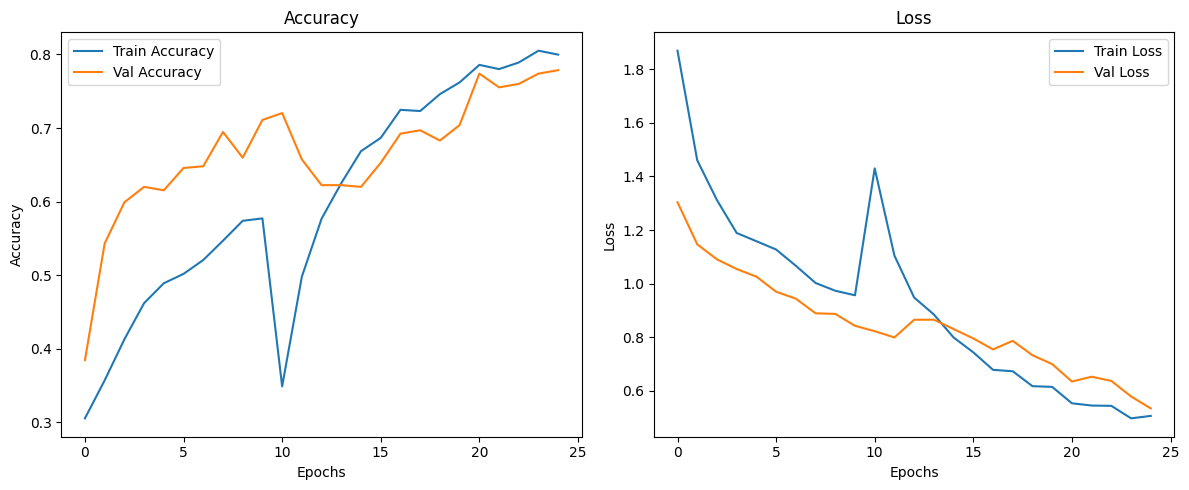

In [36]:
# === 8. Plot Accuracy & Loss ===
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.title('Accuracy'); plt.xlabel('Epochs'); plt.ylabel('Accuracy'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.title('Loss'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1, history2)

13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step

📋 Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.64      0.29      0.40       100
meningioma_tumor       0.79      0.26      0.39       115
        no_tumor       0.42      0.93      0.58       105
 pituitary_tumor       0.73      0.78      0.76        74

        accuracy                           0.55       394
       macro avg       0.65      0.57      0.53       394
    weighted avg       0.64      0.55      0.51       394



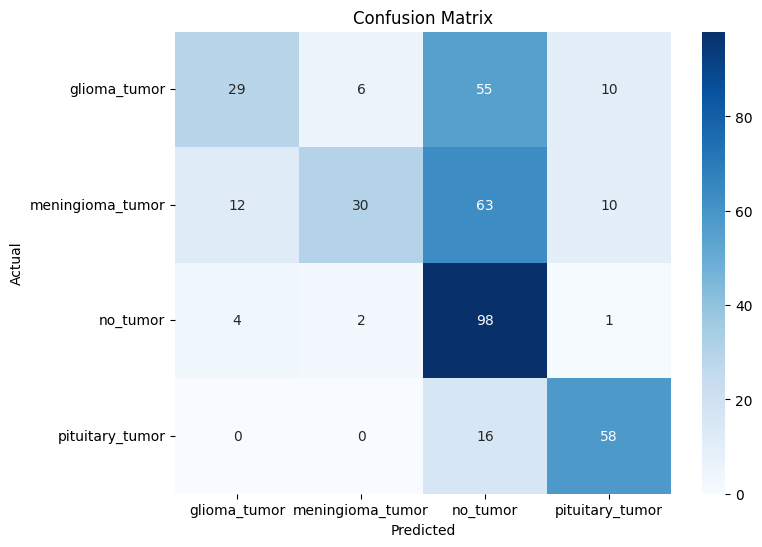

In [37]:


# === 9. Evaluation: Confusion Matrix + Report ===
y_true = test_flow.classes
y_probs = model.predict(test_flow)
y_pred = np.argmax(y_probs, axis=1)
labels = list(test_flow.class_indices.keys())

print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()



In [38]:
# === 10. Training History Summary ===
def training_summary(h1, t1, h2, t2):
    df = pd.DataFrame({
        'Epoch': list(range(1, len(h1.history['accuracy']) + len(h2.history['accuracy']) + 1)),
        'Train Accuracy': h1.history['accuracy'] + h2.history['accuracy'],
        'Val Accuracy': h1.history['val_accuracy'] + h2.history['val_accuracy'],
        'Train Loss': h1.history['loss'] + h2.history['loss'],
        'Val Loss': h1.history['val_loss'] + h2.history['val_loss'],
        'LR': t1.lrs + t2.lrs,
        'Time (s)': t1.epoch_times + t2.epoch_times
    }).round(4)

    return df.style.set_caption("📊 Training Summary").format({'LR': '{:.2e}', 'Time (s)': '{:.2f}'})\
        .background_gradient(subset=['Train Accuracy', 'Val Accuracy'], cmap='Greens')\
        .background_gradient(subset=['Train Loss', 'Val Loss'], cmap='Oranges_r')

training_summary(history1, tracker1, history2, tracker2)



,Epoch,Train Accuracy,Val Accuracy,Train Loss,Val Loss,LR,Time (s)
0,1,0.305600,0.384600,1.869900,1.303900,1.00e-04,157.45
1,2,0.357200,0.543100,1.460700,1.146700,1.00e-04,148.54
2,3,0.412900,0.599100,1.311900,1.090400,1.00e-04,151.96
3,4,0.462100,0.620000,1.189000,1.054400,1.00e-04,150.18
4,5,0.489100,0.615400,1.158200,1.025900,1.00e-04,148.36
5,6,0.501800,0.645700,1.127200,0.969600,1.00e-04,168.59
6,7,0.520700,0.648000,1.066500,0.943700,1.00e-04,149.95
7,8,0.546900,0.694600,1.002300,0.889000,1.00e-04,149.11
8,9,0.573900,0.659700,0.973200,0.886700,1.00e-04,147.75
9,10,0.577200,0.711000,0.956300,0.842200,1.00e-04,150.14


In [39]:
# === 11. Save Model ===
model.save('mobilenet_brain_tumor_v2.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('mobilenet_brain_tumor_v2.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp7ug_yvxi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_318')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137892766974992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766976336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766976720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766976528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766975184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766977872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766978256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766978640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766978448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137892766975568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378927669

1/1 ━━━━━━━━━━━━━━━━━━━━ 34s 34s/step


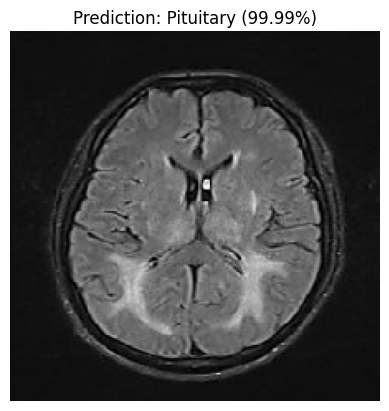

Predicted Tumor Type: Pituitary with confidence 1.00


In [62]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt

# Load your trained MobileNet model (update the path accordingly)
model = tf.keras.models.load_model('mobilenet_brain_tumor_v2.h5')

# Class labels matching your 4 tumor types (adjust as per your model)
class_labels = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

def prepare_image(img_path):
    # Load image and resize to MobileNet input size
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_expanded = np.expand_dims(img_array, axis=0)
    processed_img = preprocess_input(img_expanded)
    return processed_img, img

def predict_and_display(img_path, model):
    processed_img, original_img = prepare_image(img_path)
    preds = model.predict(processed_img)
    pred_idx = np.argmax(preds, axis=1)[0]
    pred_label = class_labels[pred_idx]
    confidence = preds[0][pred_idx]

    plt.imshow(original_img)
    plt.title(f"Prediction: {pred_label} ({confidence*100:.2f}%)")
    plt.axis('off')
    plt.show()

    return pred_label, confidence

if __name__ == '__main__':
    image_path = '/kaggle/input/brain-tumor-classification-mri/Testing/no_tumor/image(10).jpg'  # Put your tumor image path here
    predicted_class, confidence_score = predict_and_display(image_path, model)
    print(f"Predicted Tumor Type: {predicted_class} with confidence {confidence_score:.2f}")


In [63]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.4 MB/s eta 0:00:00


In [68]:
import gradio as gr
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf


def predict_image(img: Image.Image):
    img = img.convert('RGB')  # Ensure the image is in RGB format
    img = img.resize((224, 224))  # Resize to MobileNet input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image

    pred = model.predict(img_array)  # Make prediction
    predicted_class = np.argmax(pred)  # Get the index of the highest probability
    confidence = np.max(pred)  # Get the confidence score

    return {class_labels[predicted_class]: float(confidence)}  # Return the result

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),  # Input type is PIL image
    outputs=gr.Label(num_top_classes=4),  # Output type is label with top classes
    title="🧠 Brain Tumor Classification",
    description="Upload an MRI image and the model will predict the tumor type: Glioma, Meningioma, Pituitary, or No Tumor."
)

# Launch the interface
interface.launch(share=True)  # Set share=True to get a public URL


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a30da46951cd7c20af.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
